# Group 005 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [1]:
# !mkdir data
# !kaggle datasets download mrdaniilak/russia-real-estate-20182021
# !mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

In [2]:
import zipfile
with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [5]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
4191979,4600000,2020-07-31,11:59:14,54.995464,82.908230,9654,0,15,18,2,58.10,12.80,1
2240889,1680000,2019-07-21,07:20:01,56.627352,47.849069,4982,3,2,5,1,35.00,9.00,1
458365,2450000,2018-11-11,04:40:05,45.056312,39.032017,2843,2,4,21,1,43.00,11.00,1
4638082,3893595,2020-10-31,07:54:23,55.113553,61.350565,5282,2,2,22,3,80.00,10.47,1
1358586,960000,2019-03-13,12:38:17,54.944957,82.962740,9654,1,8,10,-1,32.47,5.00,1


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [6]:
MOSCOW_CODE = 81

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]

In [7]:
moscow_df.isnull().values.any()

False

In [8]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
2516795,3105385,2019,brick,21,25,1,29.4,8.2,new
2186681,7500000,2019,monolithic,2,17,2,74.9,13.5,preowned
4975647,7800000,2021,monolithic,7,25,2,43.8,12.0,preowned
4657123,6800000,2020,brick,3,5,3,56.0,5.5,preowned
4817489,3130000,2020,brick,3,22,1,39.5,12.0,preowned


# Exploration

First, we'll look at the data distributions for the ordinal data.

In [9]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,5.001920e+05,500192.000000,500192.00000,500192.000000,500192.000000,500192.000000,500192.000000
mean,4.765453e+06,2019.310803,7.05152,12.741489,1.782240,51.734531,10.364580
std,4.208466e+06,0.880217,5.71243,7.391100,0.864063,25.727061,7.177274
min,0.000000e+00,2018.000000,1.00000,1.000000,0.000000,1.000000,0.050000
25%,3.000000e+06,2019.000000,3.00000,5.000000,1.000000,38.000000,7.000000
50%,4.300000e+06,2019.000000,5.00000,12.000000,2.000000,46.200000,9.600000
75%,5.950000e+06,2020.000000,10.00000,17.000000,2.000000,62.000000,12.000000
max,2.147484e+09,2021.000000,36.00000,39.000000,9.000000,5000.000000,3000.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

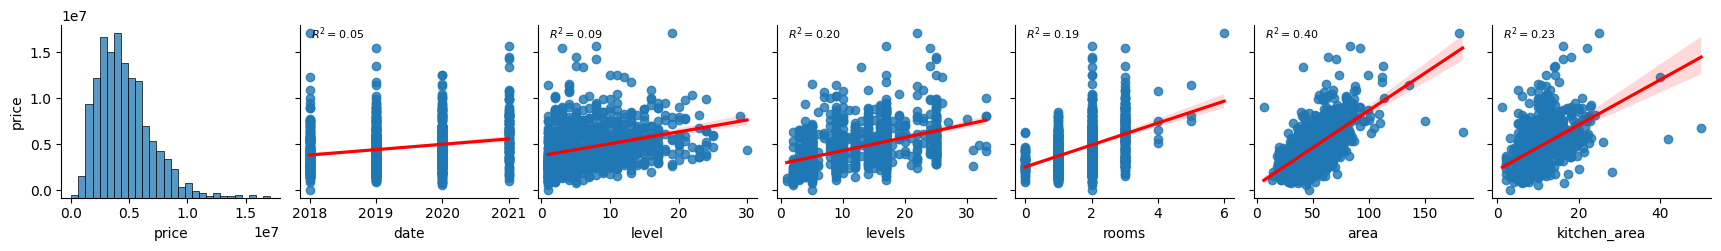

In [10]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like te might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

<Axes: >

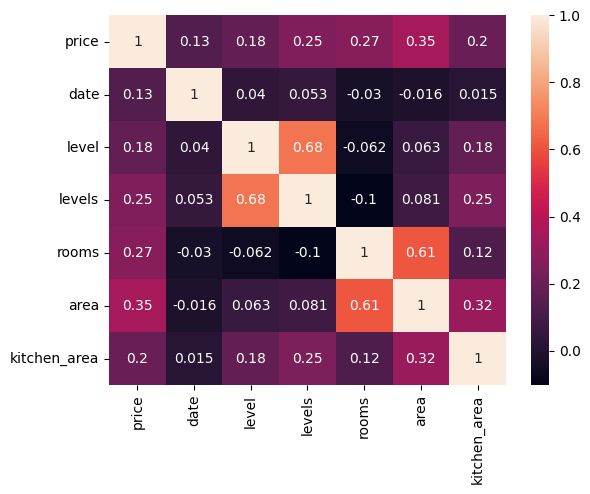

In [11]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Model Fitting

In [12]:
from sklearn.model_selection import train_test_split

X = moscow_df[['date', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

350134 train samples; 150058 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [13]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
3977271,2020,6,9,3,60.0,7.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
47727,2018,6,10,2,69.1,15.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2694124,2019,5,5,2,45.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2362412,2019,6,17,2,63.0,12.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
852955,2018,19,25,2,61.9,21.9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables.

It is also important to note that scaled data won't *negatively* impact descision trees, but we make a copy of scaled data to more explicitly demonstrate model understanding.

In [14]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['date', 'level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
1527667,-0.353996,-0.709375,0.576643,0.252737,0.434362,-0.060068,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4144679,0.783197,-0.534308,-1.046451,-0.905443,-0.798933,-0.738405,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4829776,0.783197,0.516094,0.441386,-0.905443,-1.230586,-0.892726,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1131154,-0.353996,-0.709375,-1.046451,0.252737,-0.220826,-0.568820,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4554136,0.783197,1.041295,1.252933,-0.905443,0.010417,0.279100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [15]:
# MAX_EPOCHS = 1000000

### Linear Regression

Note that SckiKit doesn't offer MAE loss for its `LinearRegression` implementation. However, `linear_model.SGDRegressor` can be made to use an MAE loss by using `epsilon_insensitive` loss and setting its $\epsilon$ hyperparam to $0$.

Note that this does mean we will be using SGD for descent, so our model will take more steps to converge and loss won't strcitly decrease, but in our case using SGD will actually be helpful since our dataset is relatively large, so each epoch will be much faster.

In [16]:
# from sklearn.linear_model import SGDRegressor

# linreg_mae_model = SGDRegressor(loss='epsilon_insensitive', epsilon=0, max_iter=MAX_EPOCHS, verbose=1)

In [17]:
# linreg_mae_model.fit(X_train_scaled, y_train)

In [18]:
# import pickle

# filename = 'trained_model.sav'
# pickle.dump(linreg_mae_model, open(filename, 'wb'))

### DNN For Regression

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

device

device(type='mps')

In [21]:
class RealEstateDataset(Dataset):
    def __init__(self, X_train, y_train, X_test, y_test, train=True, max_cache_size=800000):
        self.df = df
        self.train = train

        self.X = X_train if self.train else X_test
        self.y = y_train if self.train else y_test

        self.cache = dict()
        self.max_cache_size = max_cache_size

    def __getitem__(self, index):

        if index in self.cache.keys():
            return self.cache[index]

        X_sample = torch.tensor(self.X[index]).to(torch.float32).squeeze()
        y_sample = torch.tensor(self.y[index]).to(torch.float32).squeeze()

        if len(self.cache) >= self.max_cache_size:
            self.cache.popitem()

        self.cache[index] = (X_sample, y_sample)

        return self.cache[index]

    def __len__(self):
        return len(self.X)

In [22]:
train_dataset = RealEstateDataset(X_train_scaled.to_numpy(), y_train.to_numpy(), X_test_scaled.to_numpy(), y_test.to_numpy(), train=True)
test_dataset = RealEstateDataset(X_train_scaled.to_numpy(), y_train.to_numpy(), X_test_scaled.to_numpy(), y_test.to_numpy(), train=False)

In [23]:
class RegressionDNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionDNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1)
        )

    def forward(self, x):
        return self.model(x)

In [56]:
BATCH_SIZE = 64
EPOCHS = 10
DATA_DIMS = train_dataset[0][0].size(0)

In [57]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [58]:
from tqdm import tqdm
import sys

def train(train_dl, test_dl, epochs=EPOCHS, input_size=DATA_DIMS, lr=1e-4, print_batch_every=10000):

    model = RegressionDNN(input_size).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    model.train()

    for epoch in range(epochs):

        batch = 0
        train_loss = 0
        for data in tqdm(iter(train_dl)):
            batch += 1

            X, y = data

            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()

            pred = model(X).squeeze()

            loss = F.l1_loss(pred, y * 1e-5)
            train_loss += loss

            loss.backward()
            optimizer.step()

            if print_batch_every is not None and ((batch-1) % print_batch_every == 0):
                print(f'epoch: {epoch}\tbatch: {batch}/{len(train_dl)}\ttrain_loss: {loss.item()}', file=sys.stderr)
    
        print(f'epoch: {epoch}\ttrain_loss: {train_loss}', file=sys.stderr)

    model.eval()

    with torch.no_grad():

        batch = 0
        test_loss = 0
        for data in iter(test_dl):
            batch += 1

            X, y = data

            X.to(device)
            y.to(device)
            
            optimizer.zero_grad()

            pred = model(X) * 1e5

            loss = F.l1_loss(pred, y * 1e-5)
            test_loss += loss

            loss.backward()
            optimizer.step()

            if print_batch_every is not None and ((batch-1) % print_batch_every == 0):
                print(f'epoch: {epoch}\tbatch: {batch}/{len(test_dl)}\ttest_loss: {loss.item()}', file=sys.stderr)
    
        print(f'epoch: {epoch}\ttest_loss: {test_loss}', file=sys.stderr)

    return model

In [ ]:
trained_model = train(train_dl, test_dl, print_batch_every=None)